# Analysis of the AMLTK Pipeline
We compare 10 trials on the original data vs. for each feature engineering methods 10 trials on feature-engineered data by OpenFE and other AutoML systems doing feature engineering (like lightautoml, h2o or flaml) on different datasets.

### To Do for the User

In [430]:
# TODO 1 for the user: Adapt list of labels (has to correspond to the method names for which the AMLTK was executed in the src/amtlk/main.py main()-method
label_list = ['Original Data', 'Self-feature-engineered Data', 'autofeat Data', 'OpenFE Data', 'H2O', 'MLJAR', 'AutoGluon']
# TODO 2 for the user: Adjust part size number according to the max_trials variable defined in src/amltk/main.py
part_size = 10
# TODO 3 for the user: Define the names of the used datasets
# all 17 datasets
datasets = ["abalone dataset", "moneyball dataset", "australian dataset", "blood transfusion service center dataset", "car dataset", "churn dataset", "credit g dataset", "dna dataset", "gina dataset", "kr-vs-kp dataset", "madeline dataset", "mfeat-factors dataset", "pc4 dataset", "wilt dataset", "wine-quality-white dataset"]
# 5 small datasets
datasets = ["australian dataset", "blood transfusion service center dataset", "car dataset", "credit g dataset", "wilt dataset"]
# 1 dataset to test new methods
# datasets = ['blood transfusion service center dataset']

### Imports

In [431]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Sneak

In [432]:
df = pd.read_parquet("results_collection.parquet")
df.head()

status  trial_seed exception traceback                bucket  \
name                                                                          
trial-F4ne-4  success          42        NA        NA  results/trial-F4ne-4   
trial-PhYq-2  success          42        NA        NA  results/trial-PhYq-2   
trial-5JTG-3  success          42        NA        NA  results/trial-5JTG-3   
trial-FOyc-1  success          42        NA        NA  results/trial-FOyc-1   
trial-iyEK-6  success          42        NA        NA  results/trial-iyEK-6   

                             created_at                reported_at  \
name                                                                 
trial-F4ne-4 2024-05-22 01:37:32.165793 2024-05-22 01:37:42.051779   
trial-PhYq-2 2024-05-22 01:37:32.165548 2024-05-22 01:37:42.502607   
trial-5JTG-3 2024-05-22 01:37:32.165674 2024-05-22 01:37:42.749763   
trial-FOyc-1 2024-05-22 01:37:32.165380 2024-05-22 01:37:43.954334   
trial-iyEK-6 2024-05-22 01:37:42.504852 2024-05-22 01:37:47.457283   

              metric:accuracy [0.0, 1.0] (maximize)  \
name                                                  
trial-F4ne-4                               0.850379   
trial-PhYq-2                               0.856747   
trial-5JTG-3                               0.856747   
trial-FOyc-1                               0.856747   
trial-iyEK-6                               0.856747   

              summary:split_0:val_accuracy  summary:split_0:train_accuracy  \
name                                                                         
trial-F4ne-4                      0.846154                        0.856354   
trial-PhYq-2                      0.923077                        0.847145   
trial-5JTG-3                      0.923077                        0.847145   
trial-FOyc-1                      0.923077                        0.848987   
trial-iyEK-6                      0.923077                        0.847145   

              ...  profile:cv:train_score:memory:diff_vms  \
name          ...                                           
trial-F4ne-4  ...                                       0   
trial-PhYq-2  ...                                       0   
trial-5JTG-3  ...                                       0   
trial-FOyc-1  ...                                       0   
trial-iyEK-6  ...                                       0   

              profile:cv:train_score:memory:start_rss  \
name                                                    
trial-F4ne-4                                373571584   
trial-PhYq-2                                372736000   
trial-5JTG-3                                372916224   
trial-FOyc-1                                373669888   
trial-iyEK-6                                373325824   

              profile:cv:train_score:memory:end_rss  \
name                                                  
trial-F4ne-4                              373571584   
trial-PhYq-2                              372736000   
trial-5JTG-3                              372916224   
trial-FOyc-1                              373669888   
trial-iyEK-6                              373325824   

              profile:cv:train_score:memory:diff_rss  \
name                                                   
trial-F4ne-4                                       0   
trial-PhYq-2                                       0   
trial-5JTG-3                                       0   
trial-FOyc-1                                       0   
trial-iyEK-6                                       0   

              profile:cv:train_score:memory:unit  \
name                                               
trial-F4ne-4                               bytes   
trial-PhYq-2                               bytes   
trial-5JTG-3                               bytes   
trial-FOyc-1                               bytes   
trial-iyEK-6                               bytes   

              profile:cv:train_score:time:start  \
name          

In [433]:
# Define trials for axis labelling
trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Add an index column to the dataframe
df['index_col'] = np.arange(len(df))

if len(df) / (len(label_list) * part_size) != len(datasets):
    print("Error on the number of datasets")

# Get number of label, that has to be removed because the execution failed
failed_trials = []
for index in df['index_col']:
    if df["status"][index] == "fail":
        failed_trials.append(index)
failed_trials = [int(x / part_size) for x in failed_trials]
failed_trials = list(set(failed_trials))

# Remove failed Trials
df_success = df[df["status"] != "fail"]

# Define how many different methods we used (original data, openfe data, self-feature-engineered data, ...)
total_parts = int(df_success.shape[0] / part_size)

# Give every method a color in the plot
colors = [hsv_to_rgb([(i * 0.618033988749895) % 1.0, 1, 1]) for i in range(total_parts)] 

label_list_dataset = []
for dataset in datasets: 
    for i in range(len(label_list)):
        label_list_dataset.append(str(label_list[i]) + " - " + str(dataset))

# Remove label automatically if one of them failed (has to be in the right order)
removed_label_list = []
i = 0
for elem in failed_trials:
    elem = elem - i
    removed_label_list.append((label_list_dataset[elem], label_list_dataset.index(label_list_dataset[elem])))
    label_list_dataset.pop(elem)
    i += 1

['H2O - car dataset']
[18]


### Status

In [434]:
# Print minutes passed since execution (to check if results are the latest)
executed = df_success["created_at"][0]
now = datetime.now()
duration = now - executed
duration_in_s = duration.total_seconds()
minutes = divmod(duration_in_s, 60)[0]
print("The parquet was executed " + str(minutes) + " minutes ago.")
# Print all successful trials
print(df_success["status"].to_string(index=1))

The parquet was executed 472.0 minutes ago.
name
trial-F4ne-4     success
trial-PhYq-2     success
trial-5JTG-3     success
trial-FOyc-1     success
trial-iyEK-6     success
trial-gTHU-5     success
trial-cw0K-7     success
trial-WWSZ-8     success
trial-x65t-9     success
trial-7MpJ-10    success
trial-F4ne-4     success
trial-PhYq-2     success
trial-5JTG-3     success
trial-FOyc-1     success
trial-gTHU-5     success
trial-iyEK-6     success
trial-WWSZ-8     success
trial-cw0K-7     success
trial-x65t-9     success
trial-7MpJ-10    success
trial-F4ne-4     success
trial-PhYq-2     success
trial-5JTG-3     success
trial-FOyc-1     success
trial-iyEK-6     success
trial-gTHU-5     success
trial-WWSZ-8     success
trial-cw0K-7     success
trial-x65t-9     success
trial-7MpJ-10    success
trial-F4ne-4     success
trial-PhYq-2     success
trial-5JTG-3     success
trial-gTHU-5     success
trial-FOyc-1     success
trial-WWSZ-8     success
trial-iyEK-6     success
trial-x65t-9     success
t

In [435]:
# Get error message for failed trials
i = 0
for failed_trial in failed_trials:
    print("Error at " + str(removed_label_list[i]))
    print("Traceback : \n" + str(df["traceback"][failed_trial * part_size]) + "\n\n")
    i += 1

Error at ('H2O - car dataset', 18)
Traceback : 
Traceback (most recent call last):
  File "/Users/schaefer.bastian/miniconda3/envs/Masterarbeit/lib/python3.10/site-packages/amltk/sklearn/evaluation.py", line 747, in cross_validate_task
    for i, _split_eval in trial.profiler.each(
  File "/Users/schaefer.bastian/miniconda3/envs/Masterarbeit/lib/python3.10/site-packages/amltk/profiling/profiler.py", line 279, in each
    for i, item in enumerate(itr):
  File "/Users/schaefer.bastian/miniconda3/envs/Masterarbeit/lib/python3.10/site-packages/amltk/sklearn/evaluation.py", line 551, in _iter_cross_validate
    yield _evaluate_split(
  File "/Users/schaefer.bastian/miniconda3/envs/Masterarbeit/lib/python3.10/site-packages/amltk/sklearn/evaluation.py", line 465, in _evaluate_split
    fitted_estimator, fitting_params, train_scores, train_scorer_params = _fit(
  File "/Users/schaefer.bastian/miniconda3/envs/Masterarbeit/lib/python3.10/site-packages/amltk/sklearn/evaluation.py", line 391, in _

### Metric Accuracy

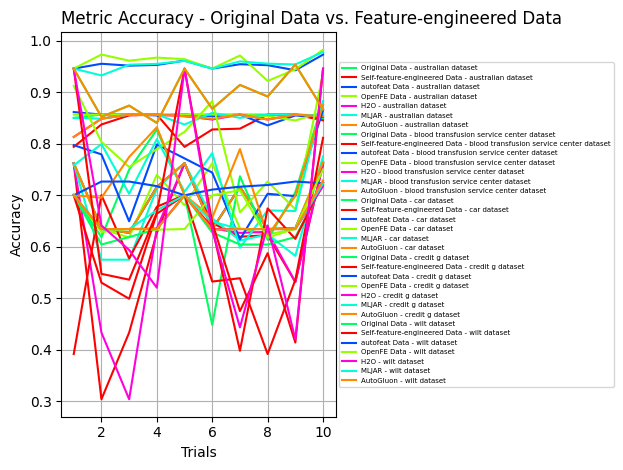

In [436]:
metric_accuracy = df_success["metric:accuracy [0.0, 1.0] (maximize)"].tolist()
data_parts = [metric_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
m = 0
removed_label_list_local = removed_label_list.copy()
for i, data_part in enumerate(data_parts):
    label = label_list_dataset[i]
    # Calculate number of labels per dataset (color-code methods)
    x = [x[1] for x in removed_label_list_local]
    if i in x:
        removed_label_list_local.pop(0)
        m += 1
    mod = len(label_list) - int(len(removed_label_list_local) / len(datasets))
    j = i%mod - int(len(removed_label_list_local))
    if j == mod - m:
        j = -m
    plt.plot(trials[:part_size], data_part, color=colors[j], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Metric Accuracy - Original Data vs. Feature-engineered Data", loc='left')
plt.legend(fontsize=5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout(rect=(0.0, 0.0, 0.99, 1.0))
plt.savefig('plots/metric_accuracy.png', dpi=300)
plt.show()

### Train, Val and Test Accuracy over all Splits

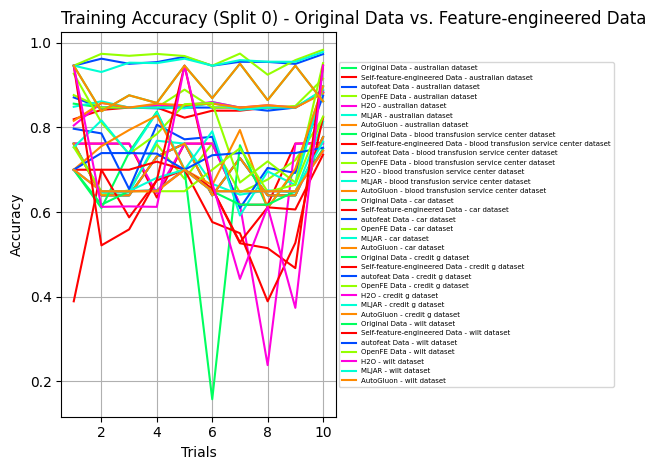

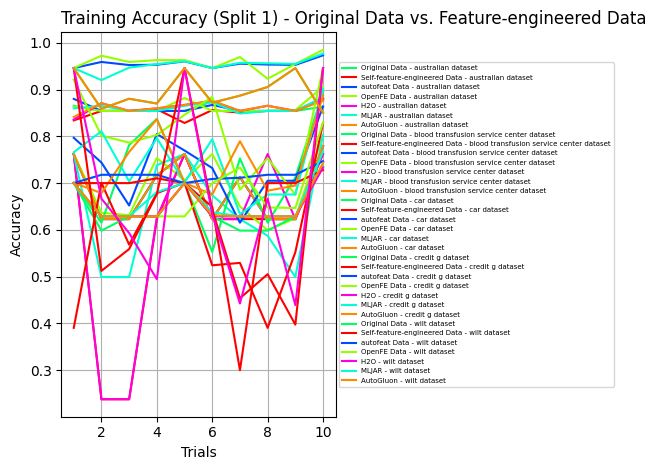

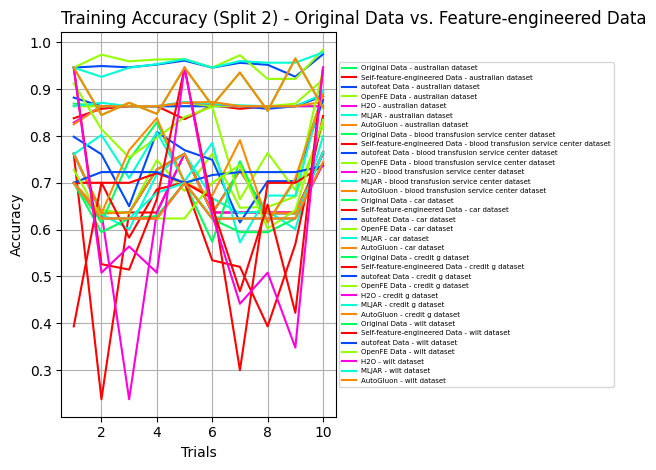

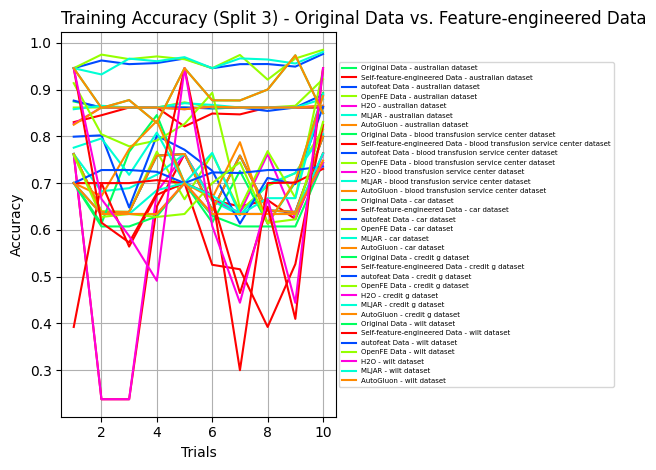

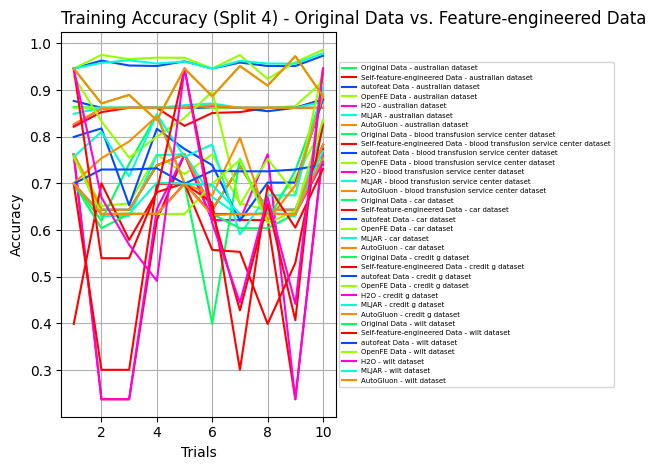

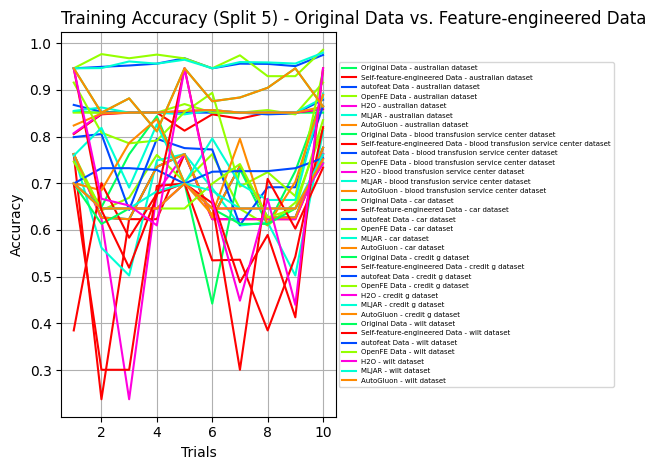

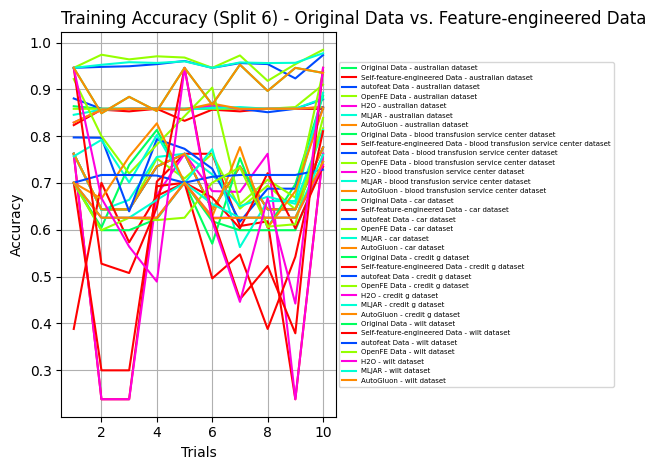

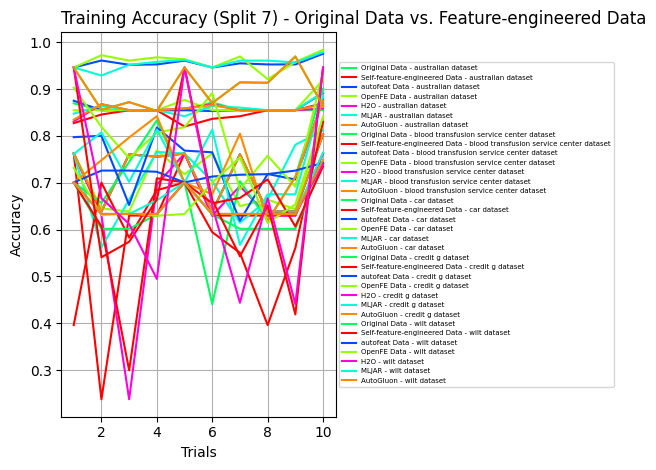

In [437]:
dataset_names = []
for i in range(8):
    dataset_name = "summary:split_" + str(i) + ":train_accuracy"
    dataset_names.append(dataset_name)

trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
k = 0
for dataset_name in dataset_names:
    train_accuracy = df_success[dataset_name].tolist()
    data_parts = [train_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
    m = 0
    removed_label_list_local = removed_label_list.copy()
    for i, data_part in enumerate(data_parts):
        label = label_list_dataset[i]
        # Calculate number of labels per dataset (color-code methods)
        x = [x[1] for x in removed_label_list_local]
        if i in x:
            removed_label_list_local.pop(0)
            m += 1
        mod = len(label_list) - int(len(removed_label_list_local) / len(datasets))
        j = i%mod - int(len(removed_label_list_local))
        if j == mod - m:
            j = -m
        plt.plot(trials[:part_size], data_part, color=colors[j], label=label)
    plt.xlabel("Trials") 
    plt.ylabel("Accuracy") 
    plt.title("Training Accuracy (Split " + str(k) + ") - Original Data vs. Feature-engineered Data", loc='left')
    plt.legend(fontsize=5, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout(rect=(0.0, 0.0, 0.99, 1.0))
    plt.show()
    k += 1

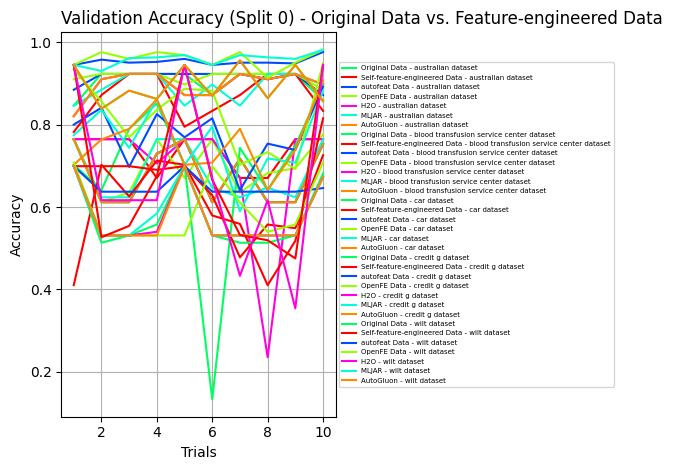

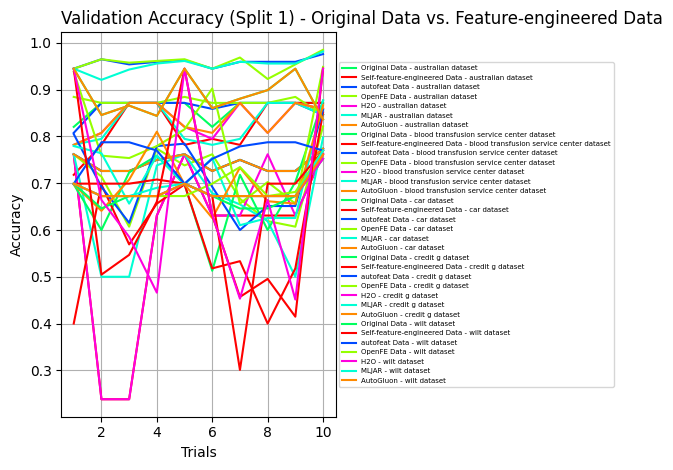

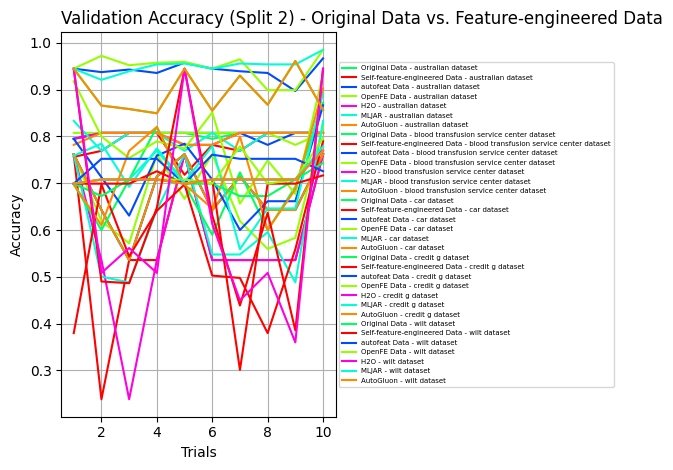

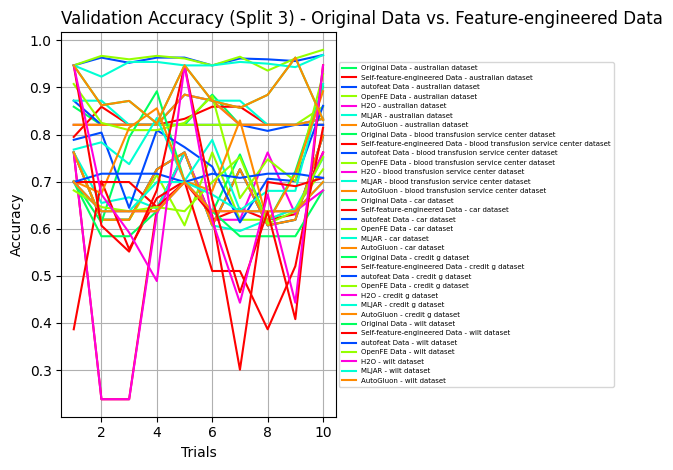

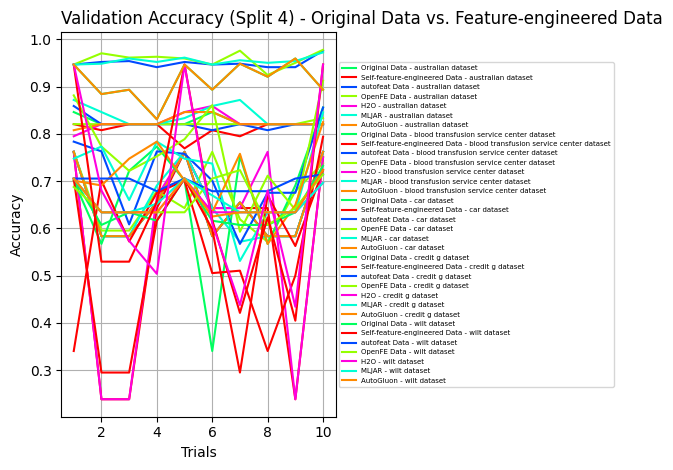

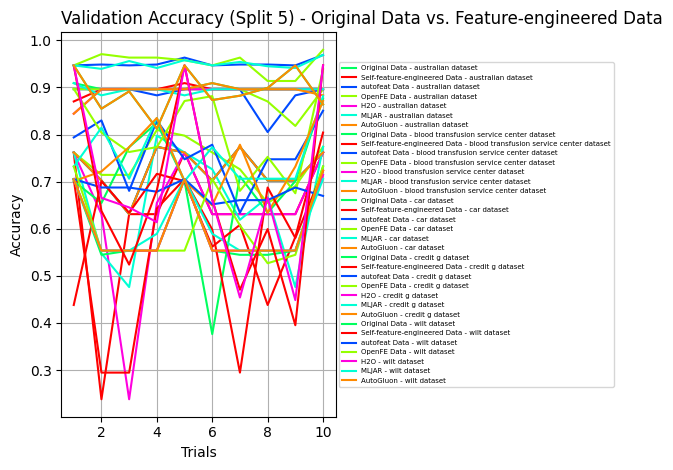

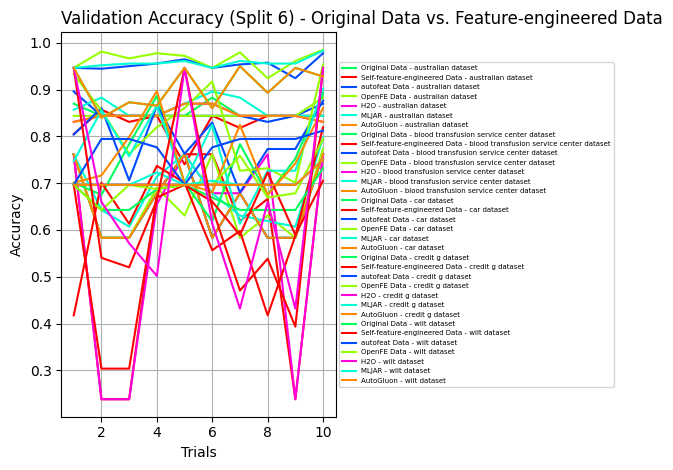

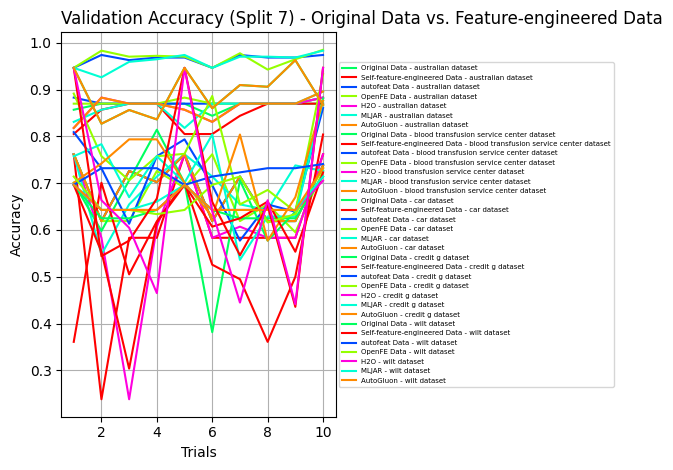

In [438]:
dataset_names = []
for i in range(8):
    dataset_name = "summary:split_" + str(i) + ":val_accuracy"
    dataset_names.append(dataset_name)

trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
k = 0
for dataset_name in dataset_names:
    val_accuracy = df_success[dataset_name].tolist()
    data_parts = [val_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
    m = 0
    removed_label_list_local = removed_label_list.copy()
    for i, data_part in enumerate(data_parts):
        label = label_list_dataset[i]
        # Calculate number of labels per dataset (color-code methods)
        x = [x[1] for x in removed_label_list_local]
        if i in x:
            removed_label_list_local.pop(0)
            m += 1
        mod = len(label_list) - int(len(removed_label_list_local) / len(datasets))
        j = i%mod - int(len(removed_label_list_local))
        if j == mod - m:
            j = -m
        plt.plot(trials[:part_size], data_part, color=colors[j], label=label)
    plt.xlabel("Trials") 
    plt.ylabel("Accuracy") 
    plt.title("Validation Accuracy (Split " + str(k) + ") - Original Data vs. Feature-engineered Data", loc='left')
    plt.legend(fontsize=5, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout(rect=(0.0, 0.0, 0.99, 1.0))
    plt.show()
    k += 1

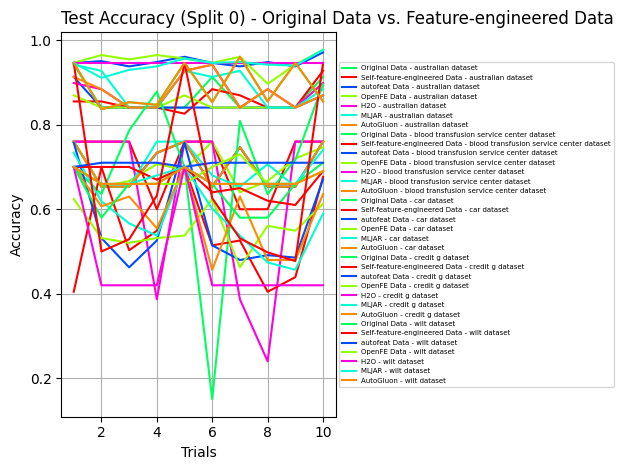

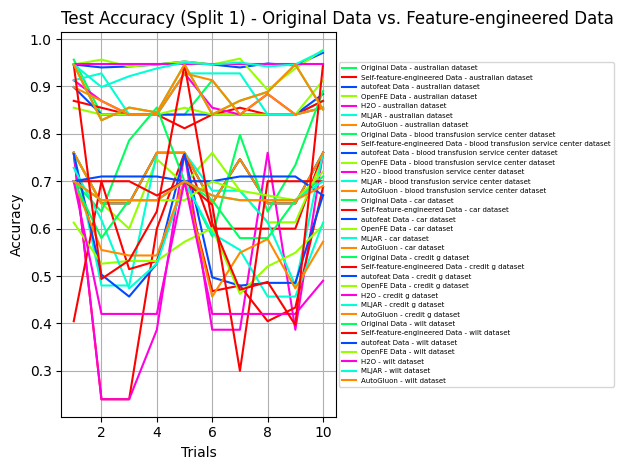

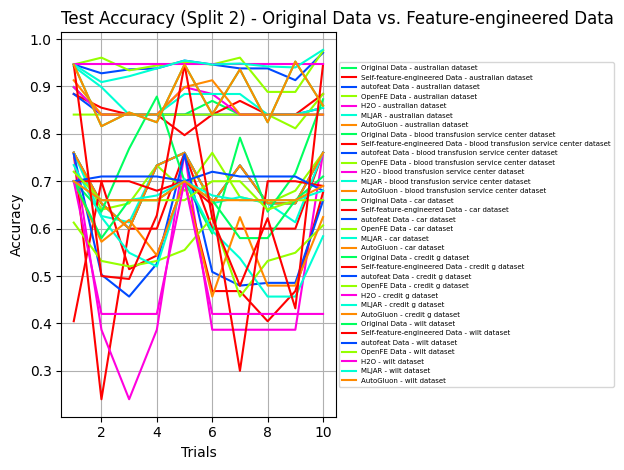

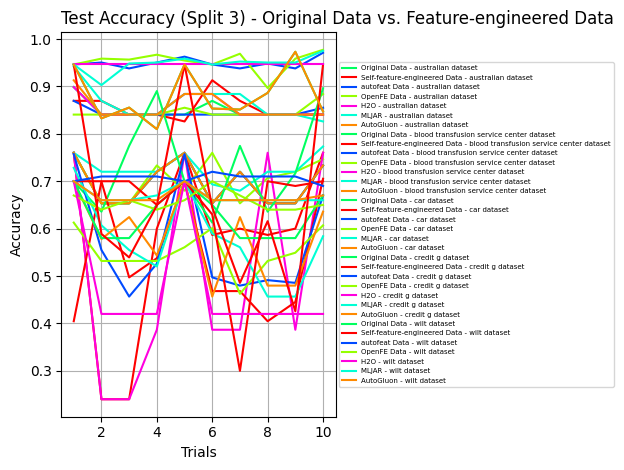

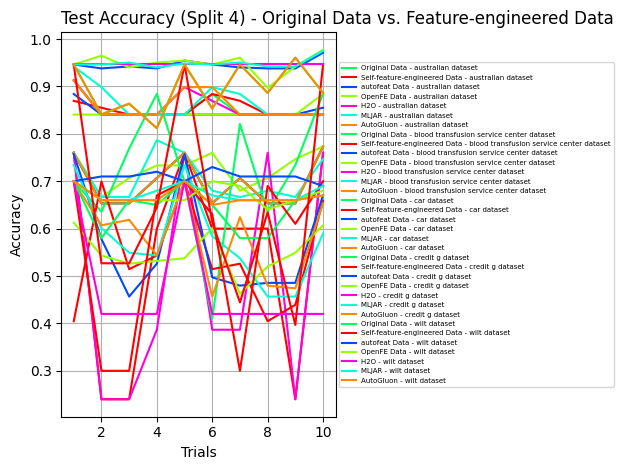

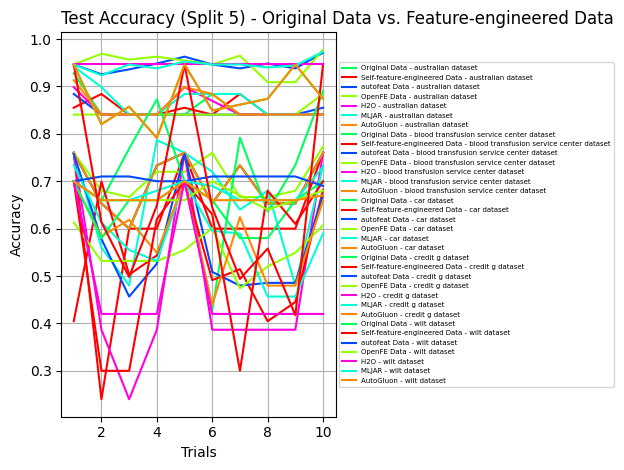

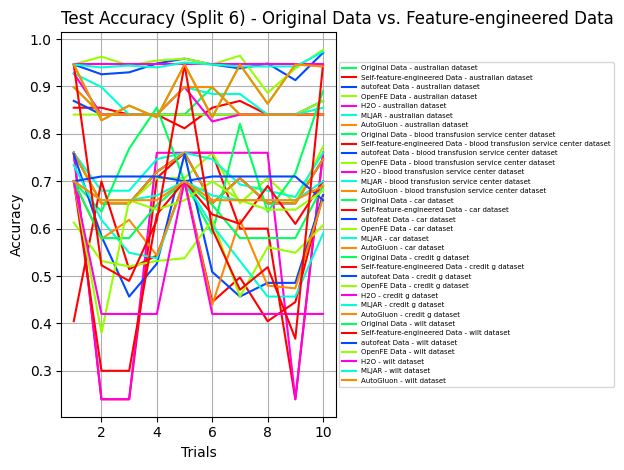

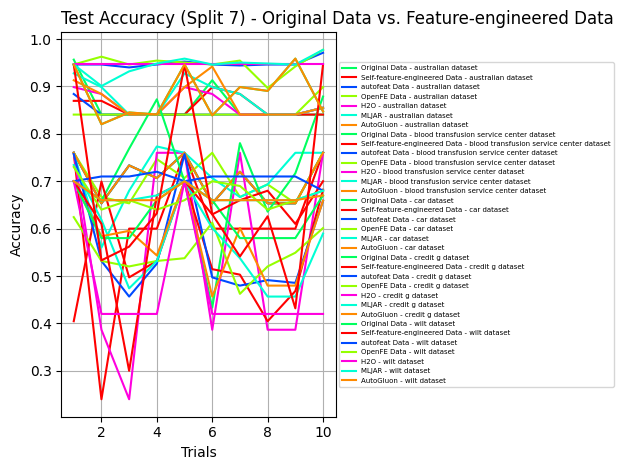

In [439]:
dataset_names = []
for i in range(8):
    dataset_name = "summary:split_" + str(i) + ":test_accuracy"
    dataset_names.append(dataset_name)

trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
k = 0
for dataset_name in dataset_names:
    test_accuracy = df_success[dataset_name].tolist()
    data_parts = [test_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
    m = 0
    removed_label_list_local = removed_label_list.copy()
    for i, data_part in enumerate(data_parts):
        label = label_list_dataset[i]
        # Calculate number of labels per dataset (color-code methods)
        x = [x[1] for x in removed_label_list_local]
        if i in x:
            removed_label_list_local.pop(0)
            m += 1
        mod = len(label_list) - int(len(removed_label_list_local) / len(datasets))
        j = i%mod - int(len(removed_label_list_local))
        if j == mod - m:
            j = -m
        plt.plot(trials[:part_size], data_part, color=colors[j], label=label)
    plt.xlabel("Trials") 
    plt.ylabel("Accuracy") 
    plt.title("Test Accuracy (Split " + str(k) + ") - Original Data vs. Feature-engineered Data", loc='left')
    plt.legend(fontsize=5, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout(rect=(0.0, 0.0, 0.99, 1.0))
    plt.show()
    k += 1

### Mean and Std Accuracy (Train, Val and Test)

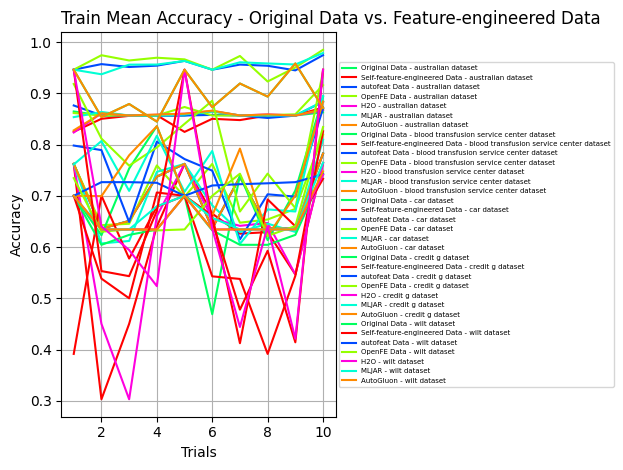

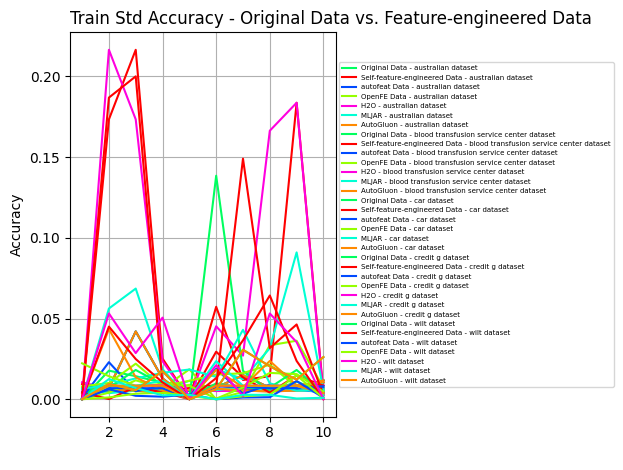

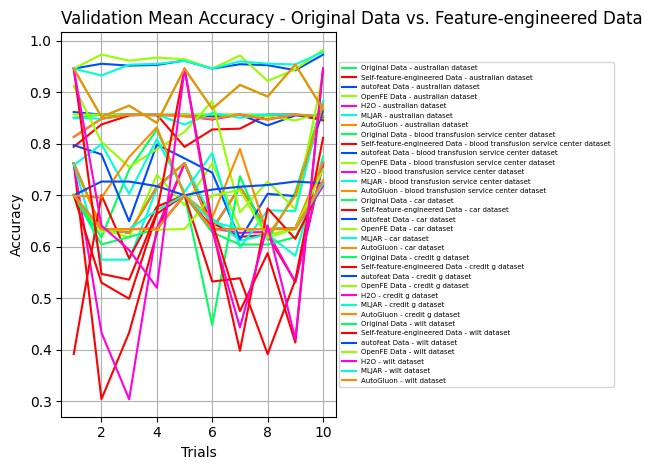

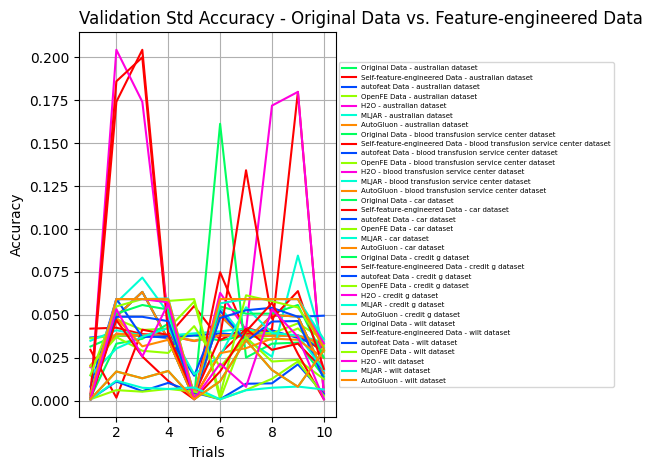

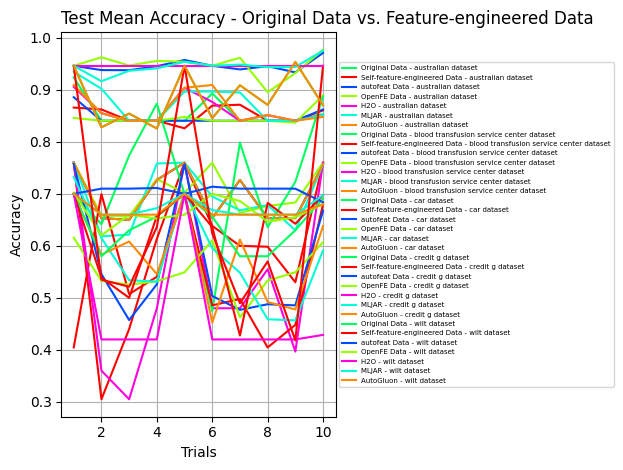

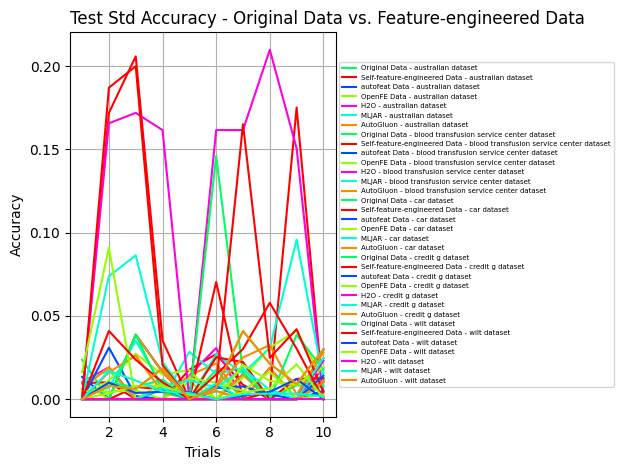

In [440]:
dataset_names = ["summary:train_mean_accuracy", "summary:train_std_accuracy", "summary:val_mean_accuracy", "summary:val_std_accuracy", "summary:test_mean_accuracy", "summary:test_std_accuracy"]
trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

train_mean_accuracy = df_success[dataset_names[0]].tolist()
data_parts = [train_mean_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
m = 0
removed_label_list_local = removed_label_list.copy()
for i, data_part in enumerate(data_parts):
    label = label_list_dataset[i]
    # Calculate number of labels per dataset (color-code methods)
    x = [x[1] for x in removed_label_list_local]
    if i in x:
        removed_label_list_local.pop(0)
        m += 1
    mod = len(label_list) - int(len(removed_label_list_local) / len(datasets))
    j = i%mod - int(len(removed_label_list_local))
    if j == mod - m:
        j = -m
    plt.plot(trials[:part_size], data_part, color=colors[j], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Train Mean Accuracy - Original Data vs. Feature-engineered Data", loc='left')
plt.legend(fontsize=5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout(rect=(0.0, 0.0, 0.99, 1.0))
plt.savefig('plots/train_mean_accuracy.png', dpi=300)
plt.show()

train_std_accuracy = df_success[dataset_names[1]].tolist()
data_parts = [train_std_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
m = 0
removed_label_list_local = removed_label_list.copy()
for i, data_part in enumerate(data_parts):
    label = label_list_dataset[i]
    # Calculate number of labels per dataset (color-code methods)
    x = [x[1] for x in removed_label_list_local]
    if i in x:
        removed_label_list_local.pop(0)
        m += 1
    mod = len(label_list) - int(len(removed_label_list_local) / len(datasets))
    j = i%mod - int(len(removed_label_list_local))
    if j == mod - m:
        j = -m
    plt.plot(trials[:part_size], data_part, color=colors[j], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Train Std Accuracy - Original Data vs. Feature-engineered Data", loc='left')
plt.legend(fontsize=5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout(rect=(0.0, 0.0, 0.99, 1.0))
plt.savefig('plots/train_std_accuracy.png', dpi=300)
plt.show()

val_mean_accuracy = df_success[dataset_names[2]].tolist()
data_parts = [val_mean_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
m = 0
removed_label_list_local = removed_label_list.copy()
for i, data_part in enumerate(data_parts):
    label = label_list_dataset[i]
    # Calculate number of labels per dataset (color-code methods)
    x = [x[1] for x in removed_label_list_local]
    if i in x:
        removed_label_list_local.pop(0)
        m += 1
    mod = len(label_list) - int(len(removed_label_list_local) / len(datasets))
    j = i%mod - int(len(removed_label_list_local))
    if j == mod - m:
        j = -m
    plt.plot(trials[:part_size], data_part, color=colors[j], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Validation Mean Accuracy - Original Data vs. Feature-engineered Data", loc='left')
plt.legend(fontsize=5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout(rect=(0.0, 0.0, 0.99, 1.0))
plt.savefig('plots/val_mean_accuracy.png', dpi=300)
plt.show()

val_std_accuracy = df_success[dataset_names[3]].tolist()
data_parts = [val_std_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
m = 0
removed_label_list_local = removed_label_list.copy()
for i, data_part in enumerate(data_parts):
    label = label_list_dataset[i]
    # Calculate number of labels per dataset (color-code methods)
    x = [x[1] for x in removed_label_list_local]
    if i in x:
        removed_label_list_local.pop(0)
        m += 1
    mod = len(label_list) - int(len(removed_label_list_local) / len(datasets))
    j = i%mod - int(len(removed_label_list_local))
    if j == mod - m:
        j = -m
    plt.plot(trials[:part_size], data_part, color=colors[j], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Validation Std Accuracy - Original Data vs. Feature-engineered Data", loc='left')
plt.legend(fontsize=5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout(rect=(0.0, 0.0, 0.99, 1.0))
plt.savefig('plots/val_std_accuracy.png', dpi=300)
plt.show()

test_mean_accuracy = df_success[dataset_names[4]].tolist()
data_parts = [test_mean_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
m = 0
removed_label_list_local = removed_label_list.copy()
for i, data_part in enumerate(data_parts):
    label = label_list_dataset[i]
    # Calculate number of labels per dataset (color-code methods)
    x = [x[1] for x in removed_label_list_local]
    if i in x:
        removed_label_list_local.pop(0)
        m += 1
    mod = len(label_list) - int(len(removed_label_list_local) / len(datasets))
    j = i%mod - int(len(removed_label_list_local))
    if j == mod - m:
        j = -m
    plt.plot(trials[:part_size], data_part, color=colors[j], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Test Mean Accuracy - Original Data vs. Feature-engineered Data", loc='left')
plt.legend(fontsize=5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout(rect=(0.0, 0.0, 0.99, 1.0))
plt.savefig('plots/test_mean_accuracy.png', dpi=300)
plt.show()

test_std_accuracy = df_success[dataset_names[5]].tolist()
data_parts = [test_std_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
m = 0
removed_label_list_local = removed_label_list.copy()
for i, data_part in enumerate(data_parts):
    label = label_list_dataset[i]
    # Calculate number of labels per dataset (color-code methods)
    x = [x[1] for x in removed_label_list_local]
    if i in x:
        removed_label_list_local.pop(0)
        m += 1
    mod = len(label_list) - int(len(removed_label_list_local) / len(datasets))
    j = i%mod - int(len(removed_label_list_local))
    if j == mod - m:
        j = -m
    plt.plot(trials[:part_size], data_part, color=colors[j], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Test Std Accuracy - Original Data vs. Feature-engineered Data", loc='left')
plt.legend(fontsize=5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout(rect=(0.0, 0.0, 0.99, 1.0))
plt.savefig('plots/test_std_accuracy.png', dpi=300)
plt.show()